<a href="https://colab.research.google.com/github/samiha-mahin/Ovarian-cancer/blob/main/AI_Driven_Sub_Type.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle tensorflow numpy pandas opencv-python matplotlib scikit-learn


In [4]:
from google.colab import files
files.upload()  # Upload your kaggle.json file


{}

In [5]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [6]:
!kaggle datasets list -s "ovarian cancer"


ref                                                             title                                                      size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
saurabhshahane/predict-ovarian-cancer                           Predict Ovarian Cancer                                   322564  2021-02-06 08:15:47.360000           2854         47  0.7058824        
yoshifumimiya/6-ovarian-cancer-datasets                         7 ovarian cancer datasets                             239456735  2024-04-21 13:37:49.933000           3464         48  0.7647059        
sunilthite/ovarian-cancer-classification-dataset                Ovarian Cancer Subtype Classification                3554471607  2023-10-31 08:34:17.390000           1512         38  1.0          

In [7]:
!kaggle datasets download -d bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology --unzip


Dataset URL: https://www.kaggle.com/datasets/bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology
License(s): CC-BY-SA-4.0


In [9]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [11]:
!kaggle datasets download -d bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology --unzip



Dataset URL: https://www.kaggle.com/datasets/bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology
License(s): CC-BY-SA-4.0


In [12]:
import os

# List all files in the directory
os.listdir()


['.config', 'kaggle (1).json', 'OvarianCancer', 'sample_data']

In [13]:
import os

# Check files inside the OvarianCancer folder
os.listdir("OvarianCancer")


['Mucinous',
 'Non_Cancerous',
 'Endometri',
 'README.txt',
 'Serous',
 'Clear_Cell']

In [14]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [15]:
# Define dataset path
DATASET_PATH = "OvarianCancer"  # Change if needed


In [16]:
# Cancer classes (based on folder names)
classes = ["Mucinous", "Non_Cancerous", "Endometri", "Serous", "Clear_Cell"]
class_mapping = {class_name: i for i, class_name in enumerate(classes)}


In [17]:
# Image size for model
IMG_SIZE = 224


In [18]:
# Lists to store images & labels
X, y = [], []


In [21]:
# Read images from each class folder
for class_name in classes:
    class_path = os.path.join(DATASET_PATH, class_name)

    # Check if folder exists
    if not os.path.exists(class_path):
        continue  # Skip if folder doesn't exist

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        # Read & resize image
        img = cv2.imread(img_path)
        if img is None:
            continue  # Skip unreadable images

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0  # Normalize
        X.append(img)
        y.append(class_mapping[class_name])  # Assign label

In [22]:
# Convert to NumPy arrays
X = np.array(X)
y = to_categorical(y, num_classes=len(classes))  # One-hot encode labels

# Split into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dataset loaded: {len(X)} images")

Dataset loaded: 497 images


In [23]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

# Load pre-trained VGG19 model
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add new layers
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(classes), activation="softmax")(x)

# Create model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=8, verbose=1)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 396s 8s/step - accuracy: 0.3024 - loss: 1.9577 - val_accuracy: 0.3700 - val_loss: 1.5314
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 378s 8s/step - accuracy: 0.5307 - loss: 1.2629 - val_accuracy: 0.3100 - val_loss: 1.3966
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 377s 8s/step - accuracy: 0.6232 - loss: 1.0581 - val_accuracy: 0.5600 - val_loss: 1.2344
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 380s 8s/step - accuracy: 0.6735 - loss: 0.9592 - val_accuracy: 0.5800 - val_loss: 1.0932
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 380s 8s/step - accuracy: 0.6560 - loss: 0.8401 - val_accuracy: 0.6400 - val_loss: 0.9943


In [24]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Save model
model.save("vgg19_ovarian_cancer_model.h5")
print("Model saved successfully!")


4/4 ━━━━━━━━━━━━━━━━━━━━ 76s 17s/step - accuracy: 0.6497 - loss: 0.9878


Test Accuracy: 0.64
Model saved successfully!


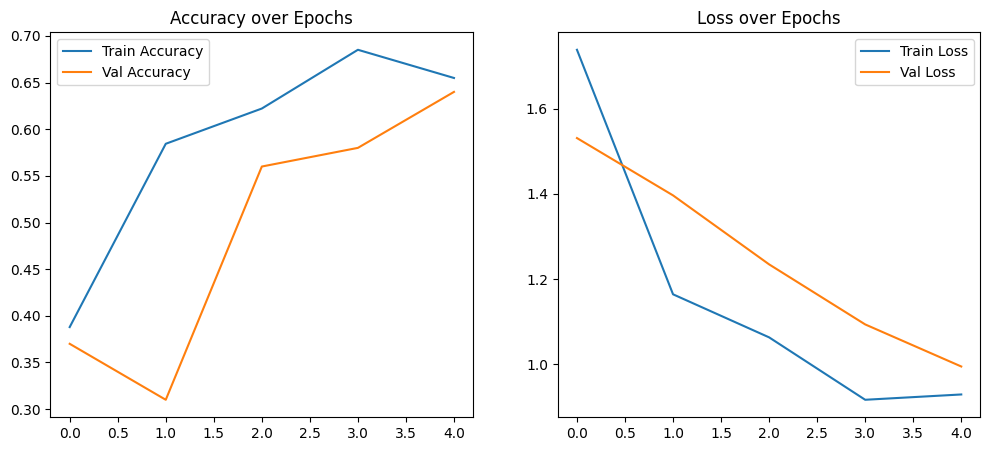

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.show()
